# Week1
## Load package

In [1]:
# libraries
import torch
from torch.utils.data import Dataset,DataLoader
import glob
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm 
# local imports
import MNIST_dataloader
from scipy import linalg
import os
import bokeh
from ISTA import ISTAI_main
PATH = os.path.join(os.getcwd(),'Fast_MRI_Knee')
print('Folders in the Fast_MRI_Knee:',os.listdir(PATH)) # os.listdir(PATH)
# Batch size
batch_size = 64
# Load train and test
train_loader, test_loader = MNIST_dataloader.create_dataloaders(PATH, batch_size)



/Users/lynch_mini/Documents/SML/5LSL0_HW/.venv/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Folders in the Fast_MRI_Knee: ['MNIST', 'test', 'train']


In [2]:
if  torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
# from google.colab import drive
# drive.mount('/content/drive')

# import os
# path="/content/drive/MyDrive/Assignment4/Code - for students"
# os.chdir(path)
# os.listdir(path)

## Plot the example

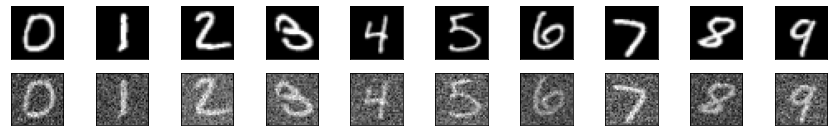

In [3]:
examples = enumerate(test_loader)
_, (x_clean_example, x_noisy_example, labels_example) = next(examples)
plt.figure(figsize=(12,2))
for i in range(10):
    plt.subplot(2,10,i+1)
    plt.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])
    
    plt.subplot(2,10,i+11)
    plt.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.xticks([])
    plt.yticks([])

plt.tight_layout()
# plt.savefig("data_examples.png",dpi=300,bbox_inches='tight')
plt.show()

In [2]:
# Load data
x_clean_train = train_loader.dataset.Clean_Images
x_noisy_train = train_loader.dataset.Noisy_Images
labels_train  = train_loader.dataset.Labels

x_clean_test  = test_loader.dataset.Clean_Images
x_noisy_test  = test_loader.dataset.Noisy_Images
labels_test   = test_loader.dataset.Labels

# use these 10 examples as representations for all digits
x_clean_example = x_clean_test[0:10,:,:,:]
x_noisy_example = x_noisy_test[0:10,:,:,:]
labels_example = labels_test[0:10]

Data shape and matrix shape.

In [5]:
x_clean_train.size() #60000 examples of 28x28 pixels in grayscale torch.Size([60000, 1, 32, 32])

(x_clean_example[0])
# tensor([[[-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          ...,
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.],
#          [-1., -1., -1.,  ..., -1., -1., -1.]]])

x_clean_example[0][0] # [1, 32, 32]) --> 1, 1024

tensor([[-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        ...,
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.],
        [-1., -1., -1.,  ..., -1., -1., -1.]])

## a - Implement ISTA for MNIST denoising.
Input requires Stepsize - `mu`, shrinkage parameter - `shrinkage`, number of iteration `K`, and measurement Batch of MNIST images[10 images \ Matrix] `y`.

Output reconstructions `x_k`. \
In the soft thershold. \
$$
\begin{equation*}
    soft_T(x)= sign(x_i)(|x_i|-T)
\end{equation*}
$$

$\alpha$ - step size 

$g_1 = A^T(y-Ax_1)$ 

$x_2 = x_1 + \alpha * (A^T(y-Ax_1)) $ 

$\hat{x}=sign(x_2)max(|x_2|-\alpha*\lambda,0)$  -  the last estimate

`reconstruction error error`

$x^{k+1}:=S_{\lambda \eta}(x^k-\eta A^T(Ax^k-y))$

[Reference](https://nikopj.github.io/blog/understanding-ista/)

## ISTA
### a - b

In [6]:
# from matplotlib.image import imread
# import numpy as np
# from scipy import linalg
# import torch

# class ISTAI_main(object):
#     def __init__(self):
#         # ,mu,shrinkage,K,y
#         super(ISTAI_main, self).__init__()


    
#     def softthreshold(self,x,theta):
#         """softthreshold, x - input, theta - shrinkage parameters: mu*lambda"""      
#         return torch.multiply(torch.sign(x) ,torch.maximum(torch.abs(x) - theta, torch.tensor(0.)))

#     def ISTA(self,mu,lmbd,K,y:torch.tensor)->torch.tensor:
#         """
#         # input 
#         - y  = input each batch \\
#         - mu = constant - step size \\
#         - lmbd = Lambda - Lipschitz continuous \\
#         - K - max iteration \\
#         """        
#         # [32,32]
#         A = torch.diag_embed(torch.flatten(y)) # Diagnoal matrix - diagonal length = 1024
#         x = torch.zeros(len(torch.flatten(y))) # 1024 zero
#         error = []

#         for i in range(K):
#             # g = torch.transpose(A,0,1)@(torch.flatten(y)-A@x) 
#             # torch.transpose(A,0,1)
#             x_2 = x +mu*A.T@(torch.flatten(y)-A@x) # mu = 1/L
#             shrinkage = mu*lmbd
#             x_hat = self.softthreshold(x_2, shrinkage)
#             error = torch.nn.functional.mse_loss(x_hat,x)
#             if error < 1e-7:
#                 break
#             else:
#                 x = x_hat   

#         return torch.tensor(x_hat)

#     # def forward(self,mu,lmbd,K,y):
#     #     x_hat, error = self.ISTA(mu,lmbd,K,y)
#     #     return x_hat, error

/Users/lynch_mini/Documents/SML/5LSL0_HW/Assignment4/Code - for students/ISTA.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(x_hat)


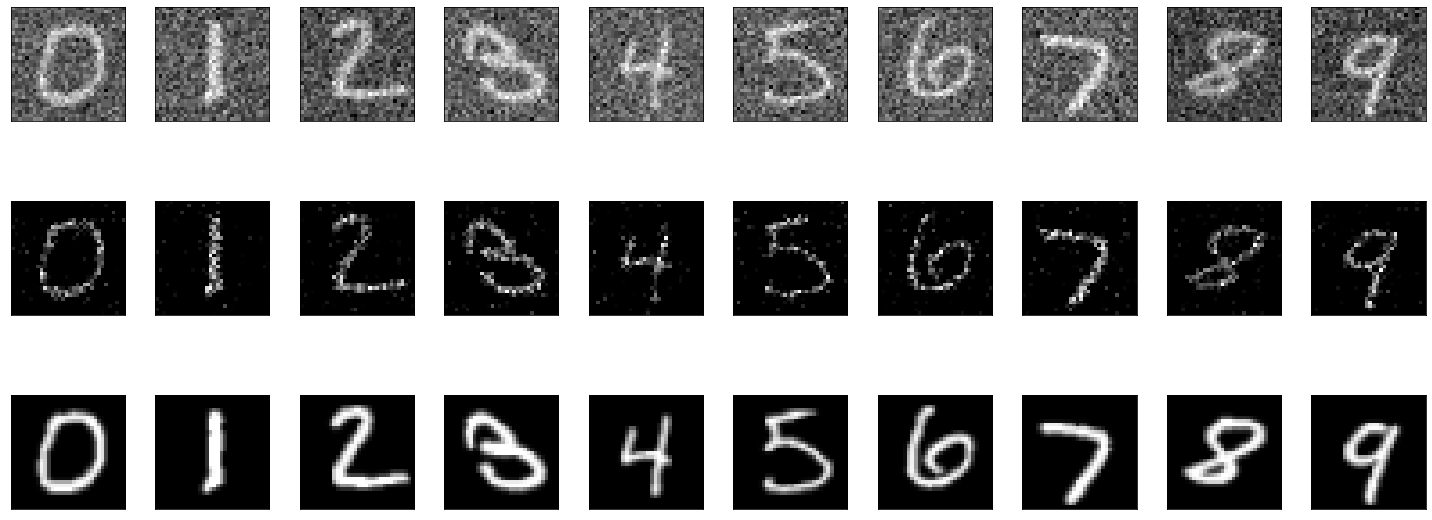

In [3]:
from ISTA import *
Ex1 = ISTAI_main()

# ------------Tuning parameters-----------------------------------
mu = 0.01
lmbd = 0.9
K=10
# ----------------------------------------------------------------
Ex1 = ISTAI_main()
x_hat = dict()

for i in range(10):
    y = x_noisy_example[i,0,:,:]+1
    x_hat[i]= Ex1.ISTA(mu,lmbd,K,y)

fig = plt.figure(figsize=(20,10))
for i in range(10):
    ax1 = fig.add_subplot(3, 10, i+1)
    ax1.imshow(x_noisy_example[i,0,:,:],cmap='gray')
    plt.yticks([])
    plt.xticks([])
    plt.tight_layout()
    plottable_image = x_hat[i].reshape([32,32])
    ax = fig.add_subplot(3, 10, i+11)
    ax.imshow(plottable_image,cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
    ax2 = fig.add_subplot(3, 10, i+21)
    ax2.imshow(x_clean_example[i,0,:,:],cmap='gray')
    plt.tight_layout()
    plt.yticks([])
    plt.xticks([])
Image_path = os.path.join(os.getcwd(),'Image')
# plt.savefig(os.path.join(Image_path,'Ex1.png'),dpi=300,bbox_inches='tight')

### C )
- Run in entire of test set
- report the resulting mean squared error 


In [8]:
np.shape(x_clean_test[0,0,:,:])
np.shape(x_hat[0])

torch.Size([1024])

In [9]:
# # Ex2 = ISTAI_main()
# backgroud_coeff=1
# yt=x_noisy_test.flatten(1)
# ytgt=x_clean_test.flatten(1)
# # x=Ex2.ISTA(mu,lmbd,K,y+backgroud_coeff)
# xt=Ex1.ISTA(mu,lmbd,K,yt+backgroud_coeff)
# mse=torch.nn.MSELoss()
# loss=mse(xt,ytgt)
# print(loss)

In [24]:
from ISTA import *
Ex1 = ISTAI_main()

# ------------Tuning parameters-----------------------------------
mu = 0.01
lmbd = 0.9
K=10
# ----------------------------------------------------------------
Ex1 = ISTAI_main()
x_hat = dict()
len(x_noisy_test)

10000

In [6]:
from bokeh.plotting import figure,show
from bokeh.io import export_png
from bokeh.io.export import get_screenshot_as_png
import matplotlib.pyplot as plt
from bokeh.io import output_notebook

total_loss = 0
x_hat_2 = dict()
loss_iter =[]
ISTA_loss = []
loss_function = torch.nn.MSELoss()

for index_,tensor in enumerate(tqdm(x_noisy_test)):
    # inputs = x_noisy_test+
    i = index_
    # y = 
    x_hat_2[i] = Ex1.ISTA(mu,lmbd,K,x_noisy_test[i,0,:,:]+1)
    loss = loss_function(x_hat_2[i],torch.flatten(x_clean_test[i,0,:,:])+1)
    # loss.backward()
    loss_iter.append(loss.data)
    total_loss += loss.data

    ISTA_loss.append(total_loss/len(x_noisy_test))

print(f'MSE loss:{total_loss/len(x_noisy_test)}')
    # ISTA_loss.append()
    # ISTA_loss.append(torch.nn.MSELoss(x_hat_2[i],x_clean_test[i,0,:,:]))



# for range(loss_function):
#     print()
# print(loss_function)

# sys.stdout.flush()
# for batch_idx,(x_clean,x_noisy,_) in enumerate(tqdm(test_loader)):


100%|██████████| 10000/10000 [01:12<00:00, 137.12it/s]

MSE loss:0.32817378640174866


In [13]:
print(ISTA_loss[-1])

tensor(0.3282)


In [10]:

y = np.array(ISTA_loss)
x = np.linspace(0,len(x_noisy_test),num=len(x_noisy_test))
p = figure(title='EX1',y_axis_label='ISTA_loss', x_axis_label='Iteration')
p.line(x, y,line_width=2)
# export_png(p, filename="Ex2_c.png")
show(p,notebook_handle=True)
output_notebook()

Loading BokehJS ...

### Loss
tensor(0.7632)